# Описание формата исходных данных

assets.json - описание активов модели

Формат описания:  
title - наименование актива, должно совпадать с используемым в матрице уязвимости и описании FT  
valuable - признак ценности актива (сейчас не используется)  
TTR - время восстановления актива (должно рассчитываться при подготовке входных данных симуляции, здесь - задается одним числом)  
Network - список логических сегментов актива (массив строк)  
Local - список локлаьных сегментов актива  
Physical - список физических сегментов актива  

FT.json - описание дерева неисправностей

Корневой узел должен быть ровно один  
каждый узел содержит атрибуты:  
name - имя узла, совпадающее с атрибутом title в описании активов (assets.json)  
impact - величина ущерба для узла дерева (по умолчанию - 0)  
node_type - тип узла. Допустимые варианты:  
basic - простое событие (лист дерева)  
root - корневое событие (начало дерева)  
and - логическое И  
or - логическое ИЛИ  
k from n - мажоритарное ИЛИ. Для типа "k from n" обязательно должен быть указан атрибут k (иначе будет принят k = 1)  
childs - дочерние атрибуты. Не должно быть у атрибутов типа "basic" (проверка не реализована)  


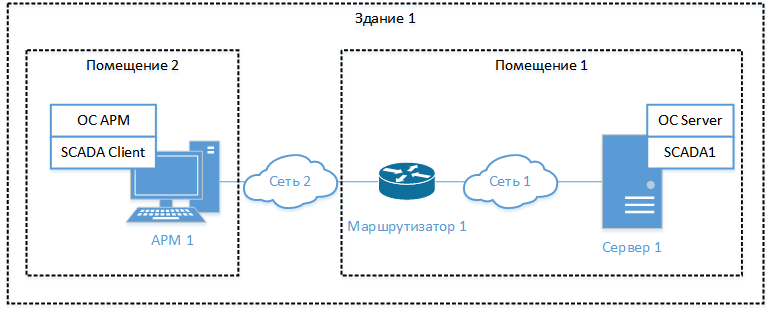

# Импорт библиотек

In [192]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import json
import random
import time

# Чтение исходных данных

In [193]:
import os
#os.chdir('D:\Google\work\ПОАР\Model\simattack')
nb = True
input_data = 'example1'



assets = pd.read_json('.\\' + input_data + '\\assets.json',orient='records')
assets['t_recover'] = 0


In [194]:
vulner = pd.read_excel('.\\' + input_data + '\\data.xlsx',sheet_name='Vulnerabilities', index_col='id')
counter_m = pd.read_excel('.\\' + input_data + '\\data.xlsx',sheet_name='C-Measures', index_col='id')
prevent_matrix = pd.read_excel('.\\' + input_data + '\\data.xlsx',sheet_name='Measures-Vuln-P', index_col='id', dtype=object)
detect_matrix = pd.read_excel('.\\' + input_data + '\\data.xlsx',sheet_name='Measures-Vuln-D', index_col='id', dtype=object)
vuln_matrix = pd.read_excel('.\\' + input_data + '\\data.xlsx',sheet_name='Assets-Vuln', index_col='title', dtype=object)
#потенциал нарушителя
k = 1 

In [195]:
#перевод обозначений AV и PR в числа
vulner.loc[vulner.AV == 'P','AV'] = -np.inf
vulner.loc[vulner.AV == 'L','AV'] = 0
vulner.loc[vulner.AV == 'A','AV'] = 1
vulner.loc[vulner.AV == 'N','AV'] = 2

vulner.loc[vulner.PR == 'N','PR'] = 0
vulner.loc[vulner.PR == 'L','PR'] = 1
vulner.loc[vulner.PR == 'H','PR'] = 2

vulner.loc[vulner['s.AV'] == 'P','s.AV'] = np.inf
vulner.loc[vulner['s.AV'] == 'L','s.AV'] = 0
vulner.loc[vulner['s.AV'] == 'A','s.AV'] = 1
vulner.loc[vulner['s.AV'] == 'N','s.AV'] = 2

vulner.loc[vulner['s.PR'] == 'N','s.PR'] = 0
vulner.loc[vulner['s.PR'] == 'L','s.PR'] = 1
vulner.loc[vulner['s.PR'] == 'H','s.PR'] = 2

In [196]:
#рассчитываем вероятность реализации уязвимости
cont_counter_m = counter_m[counter_m['Период'] == 0]

In [197]:
for (vuln, prob) in prevent_matrix.iteritems():
    vulner.at[vuln, 'P_v'] = (1 - prob[cont_counter_m.index]).prod() * k * vulner.at[vuln,'Prob']
for (vuln, prob) in detect_matrix.iteritems():
    vulner.at[vuln, 'P_d'] = 1 - (1 - prob[cont_counter_m.index]).prod()
    

# Построение графа связности активов

In [198]:
Link_MG = nx.Graph()

In [199]:
Link_MG.add_nodes_from(list(assets.loc[:,'title':'valuable'].to_dict(orient='index').items()))

In [200]:
od_iter = OrderedDict()
od_iter['Physical'] = np.inf
od_iter['Network'] = 1
od_iter['Local'] = 0

In [201]:
#d_iter = {'Physical': np.inf, 'Network': 1,'Local' : 0}
for i in assets.index:
    for j in assets.index:
        if (i != j):
            for (domain, weight) in od_iter.items():
                if (len(set(assets.loc[i,domain]) & set(assets.loc[j,domain])) > 0):
                    Link_MG.add_edge(i,j,weight = weight)          
                    Link_MG[i][j]['label'] = weight


In [202]:
nt = Network('750px','750px', notebook=nb)

# populates the nodes and edges data structures
nt.from_nx(Link_MG)
nt.show('Link_MG.html')

# Построение графа переходов (всевозможных атак)

In [203]:
#CtxA
def get_asset(df, col_name, val):
    return df[df[col_name] == val]
#CtxN
def get_all_assets(df, col_name):
    return df[col_name].unique()
#Pr(a)
def get_pr_asset(df, col_name, val, pr_col_name):
    sub_df = df[df[col_name] == val]
    if len(sub_df):
        return df[df[col_name] == val][pr_col_name].max()
    else:
        return 0
#PhAdj(a)
def phys_adj(G, node):
    return [n for n in G.neighbors(node) if G.edges[node,n]['weight'] == np.inf]

In [204]:
#задаем контекст
cols = ['a_id', 'AV', 'PR', 'I']
Ctx_0 = pd.DataFrame(columns = cols)
#___________________контекст для example1___________________________________________
Ctx_0 = Ctx_0.append({'a_id' : 4, 'AV' : 0, 'PR' : 0, 'I' : 0}, ignore_index = True)
Ctx_0 = Ctx_0.append({'a_id' : 9, 'AV' : np.inf, 'PR' : 0, 'I' : 0}, ignore_index = True)
#___________________контекст для minimal___________________________________________
#Ctx_0 = Ctx_0.append({'a_id' : 0, 'AV' : 0, 'PR' : 0, 'I' : 0}, ignore_index = True)
#Ctx_0 = Ctx_0.append({'a_id' : 1, 'AV' : 0, 'PR' : 0, 'I' : 0}, ignore_index = True)


In [205]:
G_dash = nx.MultiDiGraph()

In [206]:
#инциализация графа начальным контекстом
G_dash.add_nodes_from(list(Ctx_0.index))
#nx.set_node_attributes(G_dash, Ctx_0.to_dict(orient='index'))
#вспомогательный DataFrame для более удобных выборок врешин (возможно не надо писать атрибуты в граф)
A_df = pd.DataFrame(Ctx_0)

#инициализация переменного контекста
Ctx = pd.DataFrame(Ctx_0)

In [207]:
#Основной цикл
while len(Ctx.index):

    #извлечь вершину из текущего контекста
    a_begin = Ctx.iloc[-1]
    Ctx = Ctx.drop([a_begin.name])
    if a_begin['AV'] == np.inf:
        a_end_list = phys_adj(Link_MG,a_begin['a_id'])
        a_end_list.append(a_begin['a_id'])
        for a_end_id in a_end_list:
            a_name = assets.loc[a_end_id].title
            pr_a = get_pr_asset(A_df, 'a_id', a_end_id, 'PR')
            v_index = list(vuln_matrix[vuln_matrix[a_name] == 1].index)
            v_sub_df = vulner.loc[v_index]
            v_sub_df = v_sub_df[v_sub_df.PR <= pr_a]
            for v_id, v_data in v_sub_df.iterrows():
                str_search = "(a_id == {a_id}) & (AV == {v_AV}) & (PR == {v_PR}) & (I == {I})".format(
                    a_id=a_end_id, 
                    v_AV = v_data['s.AV'], 
                    v_PR = v_data['s.PR'], 
                    I = v_data['Imp']
                )
                a_ex_ind = A_df.query(str_search).index
                #не найдена такая вершина в графе
                if len(a_ex_ind) == 0:
                    a_dict = {'a_id' : a_end_id, 'AV' : v_data['s.AV'], 'PR' : v_data['s.PR'], 'I' : v_data['Imp']}
                    A_df = A_df.append(a_dict, ignore_index = True)
                    a_series = A_df.iloc[-1]
                    a_ex_ind = a_series.name
                    G_dash.add_node(int(a_ex_ind))
                    if a_series['I'] == 0:
                        Ctx = Ctx.append(A_df.iloc[a_ex_ind])
                else:
                    a_ex_ind = a_ex_ind[0]
                G_dash.add_edge(int(a_begin.name), int(a_ex_ind), label = v_id)
    else:
        for a_end_id in Link_MG.nodes():
            if nx.algorithms.shortest_paths.generic.has_path(Link_MG, source = a_begin['a_id'], target = a_end_id):
                d = nx.shortest_path_length(Link_MG, source = a_begin['a_id'], target = a_end_id, weight = 'weight')
            else:
                d = np.inf
            a_name = assets.loc[a_end_id].title
            pr_a = get_pr_asset(A_df, 'a_id', a_end_id, 'PR')
            v_index = list(vuln_matrix[vuln_matrix[a_name] == 1].index)
            v_sub_df = vulner.loc[v_index]
            v_sub_df = v_sub_df[(v_sub_df.PR <= pr_a) & (v_sub_df.AV >= a_begin['AV'] + d)]
            for v_id, v_data in v_sub_df.iterrows():
                str_search = "(a_id == {a_id}) & (AV == {v_AV}) & (PR == {v_PR}) & (I == {I})".format(
                    a_id=a_end_id, 
                    v_AV = v_data['s.AV'], 
                    v_PR = v_data['s.PR'], 
                    I = v_data['Imp']
                )
                a_ex_ind = A_df.query(str_search).index
                #не найдена такая вершина в графе
                if len(a_ex_ind) == 0:
                    a_dict = {'a_id' : a_end_id, 'AV' : v_data['s.AV'], 'PR' : v_data['s.PR'], 'I' : v_data['Imp']}
                    A_df = A_df.append(a_dict, ignore_index = True)
                    a_series = A_df.iloc[-1]
                    a_ex_ind = a_series.name
                    G_dash.add_node(int(a_ex_ind))
                    if a_series['I'] == 0:
                        Ctx = Ctx.append(A_df.iloc[a_ex_ind])
                else:
                    a_ex_ind = a_ex_ind[0]
                G_dash.add_edge(int(a_begin.name), int(a_ex_ind), label = v_id)

In [208]:
def mk_title(s):
    s['title'] = '(' + str(s['a_id']) + ', ' + str(s['AV']) + ', ' + str(s['PR']) + ', ' + str(s['I']) + ')'
    return s
A_df['title'] = ''
A_df = A_df.apply(mk_title, axis = 1)

In [209]:
A_df['color'] = 'blue'
A_df.loc[Ctx_0.index,'color'] = 'green'
A_df.loc[A_df.I == 1,'color'] = 'red'
nx.set_node_attributes(G_dash, A_df.to_dict(orient='index'))

In [210]:
A_df

,a_id,AV,PR,I,title,color
0,4.0,0.0,0.0,0.0,"(4, 0, 0, 0)",green
1,9.0,inf,0.0,0.0,"(9.0, inf, 0.0, 0.0)",green
2,3.0,inf,0.0,0.0,"(3.0, inf, 0.0, 0.0)",blue
3,8.0,inf,0.0,0.0,"(8.0, inf, 0.0, 0.0)",blue
4,5.0,inf,0.0,1.0,"(5.0, inf, 0.0, 1.0)",red
5,0.0,inf,0.0,1.0,"(0.0, inf, 0.0, 1.0)",red
6,4.0,0.0,2.0,0.0,"(4, 0, 2, 0)",blue
7,4.0,1.0,1.0,1.0,"(4, 1, 1, 1)",red
8,4.0,inf,0.0,1.0,"(4.0, inf, 0.0, 1.0)",red
9,1.0,0.0,1.0,0.0,"(1, 0, 1, 0)",blue


In [211]:
nt = Network('750','750px', directed=True, notebook=nb)

# populates the nodes and edges data structures
nt.from_nx(G_dash)
#nt.show_buttons(filter_='physics')
nt.set_options("""
var options = {
  "physics": {
    "repulsion": {
      "springLength": 325,
      "springConstant": 0
    },
    "minVelocity": 0.75,
    "solver": "repulsion"
  }
}
"""
)
nt.show('G_dash.html')

# Поиск оптимальной стратегии атаки

## Построение минимального остова на графе переходов

In [212]:
for (u,v,d) in list(G_dash.edges):
    v_id = G_dash.edges[u,v,d]['label']
    P_v = vulner.at[v_id,'P_v']
    P_d = vulner.at[v_id,'P_d']
    G_dash.edges[u,v,d]['weight'] = -1 * np.log(P_v * (1 - P_d))
    G_dash.edges[u,v,d]['raw_weight'] = P_v * (1 - P_d)
    #print(G_dash.edges[u,v,d]['label'])

In [213]:
G_dash.add_node('start')

In [214]:
ctx_nodes = list(Ctx_0.index)

In [215]:
for u in ctx_nodes:
    G_dash.add_edge('start', u, weight = 0, raw_weight = 1)

In [216]:
ids = A_df[A_df.I == 1]['a_id'].unique()
for a_id in ids:
    #fin_node = 'fin: ' + str(a_id)
    fin_node = assets.at[a_id,'title']
    G_dash.add_node(fin_node)
    adj_fin = list(A_df[(A_df.a_id == a_id) & (A_df.I == 1)].index)
    for fin_a_id in adj_fin:
        G_dash.add_edge(fin_a_id, fin_node, weight = 0, raw_weight = 1)
   

In [217]:
B = nx.algorithms.tree.branchings.minimum_spanning_arborescence(G_dash,attr='weight', default=1, preserve_attrs=True)

In [218]:
for n in list(B.nodes()):
    if n in A_df.index:
        B.nodes[n]['color'] = A_df.at[n,'color']

In [219]:
B.nodes[0]

{'color': 'green'}

In [220]:
nt = Network('750','750px', directed=True, notebook=nb)
nt.set_options("""
  var options = {
      "layout": {
        "hierarchical": {
          "enabled": true,
          "sortMethod": "directed"
        }
      }
    }
"""
)
nt.from_nx(B)
nt.show('B.html')

## Редуцирование минимального остова до наиболее выгодных направлений атак на активы

In [221]:
was_del = True
idx = list(A_df.index)
while was_del:
    was_del = False
    for i in idx:
        if (i in B) and (len(B.edges(i)) == 0):
            B.remove_node(i)
            was_del = True

In [222]:
length = nx.single_source_dijkstra_path_length(B, 'start')

In [223]:
for n, l in length.items():
    raw_l = np.exp(-l)
    B.nodes[n]['raw_length'] = raw_l
    B.nodes[n]['length'] = l
    B.nodes[n]['title'] = 'w: ' + str(l) + ' rw: ' + str(raw_l)

In [224]:
nt = Network('750','750px', directed=True, notebook=nb)

# populates the nodes and edges data structures
nt.from_nx(B)
#nt.show_buttons(filter_=['edges'])
nt.set_options("""
  var options = {
      "layout": {
        "hierarchical": {
          "enabled": true,
          "sortMethod": "directed"
        }
      }
    }
"""
)
nt.show('B_reduce1.html')

## Поиск оптимального разреза дерева неисправностей (минимум эелемнтов, максимум вероятности успеха незаметной атаки)

In [225]:
def add_FT_nodes(tree, parent, child, level):
    d_type = {
        'basic': 0,
        'or': 0,
        'and': 1,
        'root': 1
    }
    c_node = child['name']
    #добавляем новую вершину дерева
    tree.add_node(c_node, impact=child.get('impact', 0), level = level)
    #tree.add_node(c_node, impact=child.get('impact', 0))
    #смотрим на тип вершины и переводим в потерю
    if child['node_type'] == 'k_from_n':
        #мажоритарное или - потеря вершины = k - 1
        tree.nodes[c_node]['loss'] = int(child['k']) - 1
    else:
        #в прочих случаях берем по словарю (или - 0, и - 1, по умолчанию - 0)
        tree.nodes[c_node]['loss'] = d_type.get(child['node_type'], 0)
    tree.nodes[c_node]['title'] = 'тип: {node_type} k: {loss} ущерб: {impact}'.format(
        node_type = child['node_type'], 
        loss = tree.nodes[c_node]['loss'],
        impact = tree.nodes[c_node]['impact']
    )
    if (child['node_type'] == 'k_from_n') or (child['node_type'] == 'or'):
        tree.nodes[c_node]['shape'] = 'triangleDown'
    if (child['node_type'] == 'and'):
        tree.nodes[c_node]['shape'] = 'triangle'
       
        
        
    #если  не корень (parent отличается от None)
    #добавляем ребро от потомка к предку (для последующего поиска потока)
    #у всех ребер пропускная способность = 1
    if parent:
        tree.add_edge(c_node, parent, capacity=1)
    #проходим рекурентно по всем детям
    for c in child.get('childs', []):
        #рекуррентно вызываем создание узлов
        tree = add_FT_nodes(tree, c_node, c, level + 1)
    return tree
#чтение файла с json описанием дерева неисправностей
jf = open('.\\' + input_data + '\\FT.json','r',encoding='utf-8')
FT_j = json.load(jf)

FT = nx.DiGraph()
#if len(FT_j) > 1:
#    print('Неверное дерево неисправностей: более одного корня!')
#    exit(1)
FT = add_FT_nodes(FT, None, FT_j, 0)
root_name = FT_j['name']
FT_orig = FT.copy()
FT_orig.nodes[root_name]['loss'] = 0

In [226]:
nb = True
nt = Network('750','750px', directed=True, notebook=nb)
nt.set_options("""
  var options = {
      "layout": {
        "hierarchical": {
          "enabled": true,
          "sortMethod": "directed",
          "direction" : "UD"
        }
      }
    }
"""
)

# populates the nodes and edges data structures
nt.from_nx(FT)


nt.show('FT_full.html')

In [169]:
#добавляем сток для всех вентилей (вершины с ненулевыми потерями)
#добавляем исток для всех листовых вершин
FT.add_node('s')
FT.add_node('t')
for n in FT.nodes:
    #пропускаем добавленные s и t
    if (n != 's') and (n != 't'):
        #если лист - то нужно добавить ребро от s к n
        if FT.degree(n) - len(FT.edges(n)) == 0:
            #TODO: необходимо добавить стоимость (для нахождения не просто минимального, но и оптимального набора вершин)
            if n in B.nodes():
                #ВАЖНО: алгоритм поиска максимального потока минимальной стоимости требует целочисленные веса (стоимости)
                weight = int(np.round(B.nodes[n]['length'] * 1000))
            FT.add_edge('s', n, capacity = 1 , weight = weight)
        if int(FT.nodes[n]['loss']) > 0:
            FT.add_edge(n,'t',capacity = int(FT.nodes[n]['loss']))


In [170]:
flow_dict = nx.algorithms.flow.max_flow_min_cost(FT, s = 's', t = 't')

In [171]:
for (s_node, n_dict) in flow_dict.items():
    for (t_node, flow) in n_dict.items():
        FT.edges[s_node,t_node]['flow'] = flow

In [172]:
FT.remove_node('s')
FT.remove_node('t')
for e in list(FT.edges()):
    if FT.edges[e].get('flow',0) == 0:
        FT.remove_edge(*e)


In [173]:
FT_reduce = FT.subgraph(nx.shortest_path(FT.to_undirected(),root_name))

In [174]:
nt = Network('750','750px', directed=True, notebook=nb)

# populates the nodes and edges data structures
nt.from_nx(FT_reduce)
nt.set_options("""
  var options = {
      "layout": {
        "hierarchical": {
          "enabled": true,
          "sortMethod": "directed",
          "direction" : "UD"
        }
      }
    }
"""
)

nt.show('FT.html')

In [175]:
targets = []
for n in FT_reduce.nodes():
     if FT_reduce.degree(n) - len(FT_reduce.edges(n)) == 0:
            targets.append(n)
targets

['Компонент1', 'Компонент2']

## Повторное редуцирование остова атак (оставляем только цели из оптимального разреза)

In [176]:
was_del = True
while was_del:
    was_del = False
    for i in list(B.nodes()):
        #print(str(i) + '  ' + str(B.edges(i)) + '\n')
        #удаляем все листовые вершины, не попавшие в targets
        if (len(B.edges(i)) == 0) and not(i in targets):
            B.remove_node(i)
            was_del = True

In [177]:
nt = Network('750','750px', directed=True, notebook=nb)

# populates the nodes and edges data structures
nt.from_nx(B)
#nt.show_buttons(filter_=['edges'])
nt.set_options("""
  var options = {
      "layout": {
        "hierarchical": {
          "enabled": true,
          "sortMethod": "directed",
          "direction" : "UD"
        }
      }
    }
"""
)
nt.show('B_reduce2.html')

# Симуляция процесса атаки по оптимальному сценарию

In [178]:
def mk_attack_path(B, Ctx, target):
    path = [target]
    #должна быть ровно одна вершина-предок
    n = list(B.pred[target].keys())[0]
    while not(n in Ctx):
        path.insert(0,n)
        n = list(B.pred[n].keys())[0]
    return path


In [179]:
sym_log = []
def log_msg(timestamp, msg_dict):
    global sym_log
    sym_log.append((timestamp, msg_dict))
    return

def print_msg():
    return

msg_type = {
    1 : {
        'prefix' : 'ATTACK Success',
        'desc' : 'Успешно реализована атака в отношении всех активов. Общий ущерб: {impact}'
    },
    2 : {
        'prefix' : 'ATTACK Failed',
        'desc' : 'Присутствие злоумышленника устранено на всех активах. Общий ущерб: {impact}'
        },
    3 : {
        'prefix' : 'ATTACK Failed',
        'desc' : 'Система остановлена на внеплановое обслуживание из-за действий нарушителя. Общий ущерб: {impact}',
    },
    4 : {
        'prefix' : 'INFO',
        'desc' : 'bogus'
    },
    5 : {
        'prefix' : 'ATTACK Started',
        'desc' : 'Начата эксплуатация уязвимости {v_id} в отношении актива {a_name}',
    },
    6 : {
        'prefix' : 'ATTACK Success',
        'desc' : 'Успешно завершена эксплуатация уязвимости {v_id} в отношении актива {a_name}',
    },
    7 : {
        'prefix' : 'ATTACK Detected',
        'desc' : 'Обнаружена эксплуатация уязвимости {v_id} в отношении актива {a_name}. Процесс восстановления займет {TTR} шагов',
    },
    8 : {
        'prefix' : 'IMPACT Applied',
        'desc' : 'Нанесен ущерб активу {a_name}. Текущий уровень ущерба: {impact}'
    },
    9 : {
        'prefix' : 'ATTACK Failed',
        'desc' : 'Эксплуатация уязвимости {v_id} в отношении актива {a_name} завершилась неуспешно',
    },
    10 : {
        'prefix' : 'ATTACK Detected',
        'desc' : 'Обнаружена эксплуатация уязвимости {v_id} с источника атаки {a_name}. Процесс восстановления займет {TTR} шагов'
    },
    11 : {
         'prefix' : 'IMPACT Detected',
         'desc' : 'Обнаружен скомпрометированный актив {a_name}. Процесс восстановления займет {TTR} шагов'
    }
}
    



In [180]:
def count_FT(FT, node, values):
    #если число входящих не 0, то это вентиль или корень
    if len(FT.in_edges(node)):
        #проходим по всем подчиненным вершинам вентиля
        level = 0
        impact = 0
        for suc in FT.predecessors(node):
            (delta_impact, res) = count_FT(FT, suc, values)
            level = level + res
            #для каждого отказавшего узла суммируем ущерб. Соответственно, если для более высокоуровневого узла ущерб не достигнут, 
            #то будет возвращена сумма по всем достигнутым ущербам
            impact = impact + delta_impact
        if (level > FT.nodes[node]['loss']):
            return (FT.nodes[node].get('impact',0), 1)
        else:
            return (impact, 0)
    #если это листовая вершина (элементарное событие)
    else:
        if int(node in values['title'].values):
            return(FT.nodes[node].get('impact',0), 1)
        else:
            return(0, 0)




In [181]:
def sim_attack(B, T, N, Ctx_0, targets):

    Ctx = Ctx_0.copy()
    AIP = pd.Series(dtype=object)
    path = []
    total_impact = 0
    cur_target = None
    impact = pd.DataFrame(columns=['node', 'v_id', 'v_t', 'title', 'P_d'])
    val = [list(B.pred[n].keys())[0] for n in targets]



    for t in range(1,T + 1, 1):
        #условия прекращения симуляции:
        #val = [] - все цели поражены
        if (len(val) == 0):
            #Успешно реализована атака в отношении всех активов. Общий ущерб: {impact}
            log_msg(t, {'type' : 1, 'params' : {'impact' : total_impact}})
            break
        #Ctx = [] - нарушитель побежден (не осталось никакого контекста)
        if (len(Ctx) == 0):
            #Присутствие злоумышленника устранено на всех активах. Общий ущерб: {impact}
            log_msg(t, {'type' : 2, 'params' : {'impact' : total_impact}})
            break
        #N < 0 - кончились "жизни"
        if N <= 0:
            #Система остановлена на внеплановое обслуживание из-за действий нарушителя. Общий ущерб: {impact}
            log_msg(t, {'type' : 3, 'params' : {'impact' : total_impact}})
            break


        #нет выбранной цели (начало атаки, завершили атаку на цель или изменился контекст в результате работы защитных мер)
        if not(cur_target):
            cur_target = val[0]
            path = mk_attack_path(B, Ctx, cur_target)
        #нет активной попытки атаки
        if (len(AIP) == 0):
            #берем, но не выкидываем (если атака будет неуспешной, то нужно повторять ее)
            AIP['node'] = path[0]
            AIP['v_id'] = list(B.in_edges(AIP['node'], data='label'))[0][2]
            AIP['v_t'] = vulner.at[AIP['v_id'],'t']
            AIP['title'] = assets.at[A_df.at[AIP['node'],'a_id'],'title']
            #Начата эксплуатация уязвимости {v_id} в отношении актива {a_name}
            log_msg(t,{'type' : 5, 'params' : {'v_id' : AIP['v_id'], 'a_name' : AIP['title']}})
        else:
            AIP['v_t'] = AIP['v_t'] - 1
        #время текущей атаки завершилось - проверяем результат
        if AIP['v_t'] == 0:
            #бросок кубика на успех атаки
            if vulner.at[AIP['v_id'],'P_v'] > random.random():
                #Успешно завершена эксплуатация уязвимости {v_id} в отношении актива {a_name}
                log_msg(t,{'type' : 6, 'params' : {'v_id' : AIP['v_id'], 'a_name' : AIP['title']}})
                AIP['P_d'] = vulner.at[AIP['v_id'],'P_d']
                Ctx.append(AIP['node'])
                #если дошли до целевого ущерба
                if AIP['node'] == cur_target:
                    impact = impact.append(AIP, ignore_index = True)
                    val.remove(cur_target)
                    path = []
                    cur_target = None
                    (cur_impact, flag) = count_FT(FT_orig, root_name, impact)
                    total_impact = max(total_impact, cur_impact)
                    #Нанесен ущерб активу {a_name}. Текущий уровень ущерба: {impact}
                    log_msg(t,{'type' : 8, 'params' : {'a_name' : AIP['title'], 'impact' : total_impact}})
                else:
                    junk = path.pop()
                #бросок кубика на обнаружение атаки
                if AIP['P_d'] > random.random():
                    #запуск восстановления, если ранее не было запущено
                    if assets.at[A_df.at[AIP['node'],'a_id'],'t_recover'] == 0:
                        assets.at[A_df.at[AIP['node'],'a_id'],'t_recover'] = t
                    #Обнаружена эксплуатация уязвимости {v_id} в отношении актива {a_name}. Процесс восстановления займет {TTR} шагов
                    log_msg(t,{'type' : 7, 'params' : {'v_id' : AIP['v_id'], 'a_name' : AIP['title'], 'TTR' : assets.at[A_df.at[AIP['node'],'a_id'],'TTR']}})
                    N = N - 1
                #только при успешной атаке мы убираем вершину из пути

            #атака неуспешна (бросок кубика не в пользу нарушителя)
            else:
                #Эксплуатация уязвимости {v_id} в отношении актива {a_name} завершилась неуспешно
                log_msg(t,{'type' : 9, 'params' : {'v_id' : AIP['v_id'], 'a_name' : AIP['title']}})
                atk_source =  list(B.pred[AIP['node']].keys())[0]
                if vulner.at[AIP['v_id'],'P_d'] > random.random():
                    #запуск восстановления только, если ранее не было запущено
                    if assets.at[A_df.at[atk_source,'a_id'],'t_recover'] == 0:
                        assets.at[A_df.at[atk_source,'a_id'],'t_recover'] = t
                    #Обнаружена эксплуатация уязвимости {v_id} с источника атаки {a_name}. Процесс восстановления займет {TTR} шагов
                    log_msg(t,{'type' : 10, 'params' : {'v_id' : AIP['v_id'], 'a_name' : assets.at[A_df.at[atk_source,'a_id'],'title'], 'TTR' : assets.at[A_df.at[atk_source,'a_id'],'TTR']}})
                    N = N - 1
            #сброс текущей цели атаки (для выбора следующей цели)
            AIP = pd.Series(dtype=object)
        #проходим по всем вершинам контекста в поисках тех, где сработал таймер восстановления (или случился детект)
        for ctx_node in Ctx:
            a_id = A_df.at[ctx_node,'a_id']
            asset = assets.loc[a_id]
            #если активу нанесен ущерб (каждый ход можем это обнаружить)
            if (ctx_node in impact['node'].values) and (asset['t_recover'] == 0):
                impact_node = impact.loc[impact['node'] == ctx_node]
                impact_node = impact_node.iloc[0]
                if impact_node['P_d'] > random.random():
                    assets.at[A_df.at[ctx_node,'a_id'],'t_recover'] = t
                    #Обнаружен скомпрометированный актив {a_name}. Процесс восстановления займет {TTR} шагов
                    log_msg(t,{'type' : 11, 'params' : {'a_name' : impact_node['title'], 'TTR' : assets.at[A_df.at[ctx_node,'a_id'],'TTR']}})
                    N = N - 1
            #завершено восстановление актива
            if (asset['t_recover'] > 0) and (t - asset['t_recover'] >= asset['TTR'] ):
                assets.at[a_id,'t_recover'] = 0
                #удаляем из набора impact
                idx = list(impact[impact['node'] == ctx_node].index)
                impact.drop(labels=idx, axis=0, inplace=True)
                val.extend(idx)
                #удаляем все вхождения в конекст
                idx = list(A_df[A_df['a_id'] == a_id].index)
                for idx_iter in idx:
                    if idx_iter in Ctx:
                        Ctx.remove(idx_iter)
                #после изменения контекста некоторые цели могли стать недоступны - нужно перестроить граф
                #и убрать лишнее из массива val
                sub_nodes = set()
                for b_node in Ctx:
                    sub_nodes.union(set(nx.shortest_path(B.to_undirected(),b_node)))
                B = B.subgraph(list(sub_nodes))
                val = []
                for n in targets:
                    if n in B:
                        val.append(list(B.pred[n].keys())[0])
                path = []
                cur_target = None
                AIP = pd.Series(dtype=object)
            #обход периодических мер
            for (t_idx, t_measure) in t_measures.iterrows():
                #прошел период
                if np.mod(t,t_measure['Период']) == 0:
                    #обходим вершины в контексте
                    for ctx_node in Ctx:
                        a_id = A_df.at[ctx_node,'a_id']
                        asset = assets.loc[a_id]
                        #если мера обнаружила компрометированный актив
                        if t_measure['P_d'] > random.random():
                            assets.at[a_id,'t_recover'] = t
                            #Обнаружен скомпрометированный актив {a_name}. Процесс восстановления займет {TTR} шагов
                            log_msg(t,{'type' : 11, 'params' : {'a_name' : impact_node['title'], 'TTR' : assets.at[A_df.at[ctx_node,'a_id'],'TTR']}})
                            N = N - 1
    return (t, total_impact)


In [188]:
num_sim = 100

#периодические меры
t_measures = counter_m[counter_m['Период'] != 0]

#исходные данные для симуляции:
#B - уже оптимизированное дерево
sym_log = []
#максимальное время симуляции
T = 3
#уровень бдительности ("жизни")
N = 5
#Конекст на дереве атак
Ctx_0 = list(B.succ['start'].keys())
#targets - массив предков целевых вершин (листьев) - так листья добавлялись для поиска оптимальных путей


res = {}
t_begin = time.time()
for i in range(1,num_sim + 1):
    #TODO: корректировка вероятностей с учетом погрешностей
    (t, impact) = sim_attack(B, T, N, Ctx_0, targets)
    res[impact] = res.get(impact,0) + 1
t_end = time.time()

In [189]:
t_end - t_begin

3.1530232429504395

In [190]:
res

{0: 100}

In [191]:
vulner

,Name,AV,PR,Imp,s.AV,s.PR,Prob,t,P_v,P_d
id,,,,,,,,,,
v1,Ultimate vulnerability,2,0,1,0,1,1,1,1.0,0.0


In [53]:
assets

,title,valuable,TTR,Network,Local,Physical,t_recover
0,Сервер1,1,10,[Сеть1],[Сервер1],[Помещение1],0
1,ОС Server,0,2,[Сеть1],[Сервер1],[],0
2,SCADA1,1,5,[Сеть1],[Сервер1],[],4
3,Помещение1,0,0,[],[],"[Здание1, Помещение1]",0
4,Маршрутизатор1,1,10,"[Сеть1, Сеть2]",[Маршрутизатор1],[Помещение1],4
5,АРМ1,0,5,[Сеть2],[АРМ1],[Помещение2],0
6,ОС АРМ,0,2,[Сеть2],[АРМ1],[],0
7,SCADA client,1,2,[Сеть2],[АРМ1],[],0
8,Помещение2,0,0,[],[],"[Здание1, Помещение2]",0
9,Здание1,0,0,[],[],[Здание1],0


In [54]:
prob_all = 1
for (u,v,d) in list(G_dash.edges):
    prob_all = prob_all * G_dash.edges[u,v,d]['raw_weight']

In [55]:
prob_all

3.9313892808008755e-98